In [ ]:

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'handwritten-signatures:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F57273%2F168063%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240413%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240413T073105Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D76bd506f4d115a20a40f6113533a60f0f4c8ed911ec8f7e3f6c86697c0fb9738dbb2c5c75d1db509cc51676cc0bb4fd603a5c085d6e60cb4b0321310f8171e2087fba2fa87110941e63f73baaf9bae25c4d80edc028ecc8ee0c5c02a54b9081f1456a7ad3728d94dc95b8fea444dd410976ff9afd5466aa1be1bae87fa78bbad405ea23afbaa42443713ca961326e4b79e326eaec82e5193a7ced873aa326c8dafb44e5fa3a3b18ad678d5c155e29758e7f41c29a7caeb8d6cdb6112cb344441cec62cec50aeeccf815c9106817121da17f953179e5d210e9bfe2504e7016a337229fe3fdb49edbe2f0aa762cc5407d0ed65a7b817f9e0b490e4925b37a14f60,handwritten-signature-datasets:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1384931%2F2359135%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240413%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240413T073105Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Da026505f9d9c73f6b9d175af79f2bb02910814fdfecf0a1d5f78d4fa18b843600edc12246e2da1406c0ab0a07e3f7a393aace013a35525b90fc47a3787d6e5c1c5c50f04bab1b9ce2a9eabbb8e09f7505562f01e1e0e50dbe0f3baf5024e8d60c8482c3121729b3d9d8d21e7db2f200fd8f62d75d0e8a54e86db91114e686d2a51c4e825239d3ea63f3f9a0e1d73c7dcad0f625b8eb07b518e5dd2c281e2dcecb465484d084c4a31771eb700106a9daf08956b7095e6630e8d71db3ac1b3e4ff69059571e4b4099142693ba00a926f9c851fbe5e384893513b0e94a28587a04a93fb267599bd9385098ce090745a62b812d9751fde3dbc8fb8b687a47448b632,cedardataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1512017%2F2497231%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240413%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240413T073106Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D4694718b90701c0bca8b06d6e215a26473a8194cd46b974468721434fae1be24a1651cd091442a180f920432f7c54abc01aac482511e79f72121af2319612568955cb3c66d79cecb9c1b60387c62d0dd4372125606a9037f76de22e0b7e948e0204e06651e5020fd871c480faad1812bacb8f91c685e9c0eca9bcba895da0a61b7d7bd5ac1cf1f69472ae3ef6957429f61d9116d0b1f0306b629dc5824ae295365f4e64554c4f9916c040355ad30fe5ed5a9bcf42bcb22cf8075ce5f3d8f7a245f5b35f363d40041c03fe0b2ca8a828ef1b0ad52f10e1a43b24bda01e2308f3a1f7d9da3e408dd8bb0544140a3eabac96a8eaabc902f1f49d0e34cd5fb2c857b,sroie-datasetv2:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1569295%2F2916806%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240413%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240413T073106Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D650beaf99ee0ce168096c7080a534be26c0f44750d2b8f500b56cf0537ae34a0ca53d08e1cd147c3e7152561e5a89aed0f0a2765bcf1b70fbcd2d9f69b506bb57b3bba68b8e5344f4e0882050ee1b40e6f17d3a9cb8a0df25fdf1dac394ba732b8a63897f1a5eaa1ba226ed89b665d2ca917810d4ec7cf84e70433eb566bd1af5013e6412d52288b4f6be4d84cff3959e1ab7514b9cdaab29d624bbd8354b1d33af507684d25f154777ec94af7fbba5a10769a9f18e9fc4ed34bfcbd4a0b6af73da15923dda311cc7d643be4ca2a53ff944b555ce5075e87fdcc63373bc9e14caa17924109c36ce44f65cae2d96dbd650e86466734351fcb7cc49bd0e8779557,handwritten-signature-verification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1915180%2F3151739%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240413%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240413T073106Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D95d952c20cbb0190566feb06cd4b2603945a849f9b518a47cb9eb34e2e8f35633bc26408d4b6f540704a9d8932aea7eac845b9fa7221588542cdadb8dfd2cd67be4100b12ddea08691c5aacd3534583aca878bf446f0430621c9c4544e4979180a792792c89643846f503dd5c87d6673aa4322403abe18ef11baebcb4d921d39842b425c9dbbb3daf9b629c38f2efcc55a400b61b0226e909993677544d9bc475527388c40faaa11f46eb7dd24acef4010cc63fd564b57e77e8ee16ab7043e9bb734d0747b6fd13ba3d60aa2bfd807fccfa5449b923c425921a9db7091bc5fd2a15aef3cb45af79737ed9b1d4dab3a4d3c0b5a10e0bd1189c8f88602c60301c4'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 388332310 bytes downloaded
Downloaded and uncompressed: handwritten-signatures
[==================================================] 304495326 bytes downloaded
Downloaded and uncompressed: handwritten-signature-datasets
[==================================================] 254225626 bytes downloaded
Downloaded and uncompressed: cedardataset
[==================================================] 874643738 bytes downloaded
Downloaded and uncompressed: sroie-datasetv2
[==================================================] 2253802570 bytes downloaded
Downloaded and uncompressed: handwritten-signature-verification
Data source import complete.


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

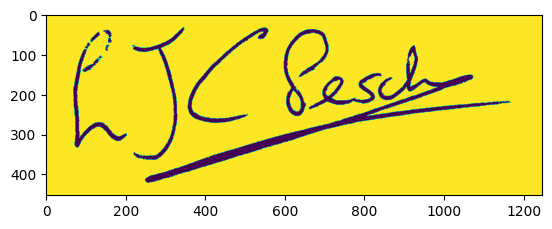

In [ ]:
img = plt.imread('../input/handwritten-signatures/sample_Signature/sample_Signature/forged/NFI-00301001.png')
plt.imshow(img)

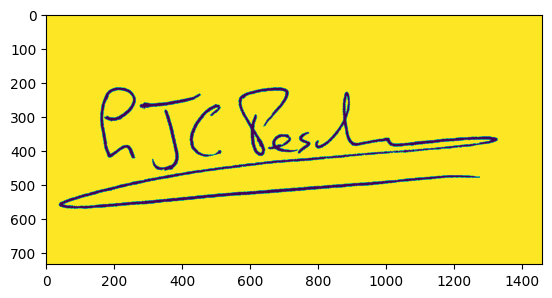

In [ ]:
img1 = plt.imread('../input/handwritten-signatures/sample_Signature/sample_Signature/genuine/NFI-00101001.png')
plt.imshow(img1)

In [ ]:
import glob
gen = [glob.glob('../input/handwritten-signatures/Dataset_Signature_Final/Dataset/dataset1/real/*.*'),
       glob.glob('../input/handwritten-signatures/Dataset_Signature_Final/Dataset/dataset2/real/*.*'),
       glob.glob('../input/handwritten-signatures/Dataset_Signature_Final/Dataset/dataset3/real/*.*'),
       glob.glob('../input/handwritten-signatures/Dataset_Signature_Final/Dataset/dataset4/real1/*.*')]

forg = [glob.glob('../input/handwritten-signatures/Dataset_Signature_Final/Dataset/dataset1/forge/*.*'),
        glob.glob('../input/handwritten-signatures/Dataset_Signature_Final/Dataset/dataset2/forge/*.*'),
        glob.glob('../input/handwritten-signatures/Dataset_Signature_Final/Dataset/dataset3/forge/*.*'),
        glob.glob('../input/handwritten-signatures/Dataset_Signature_Final/Dataset/dataset4/forge/*.*')]

Preprocessing

In [ ]:
import cv2

train_data = []
train_labels = []

test_data = []
test_labels = []

for data in range(len(gen)):
    for i in gen[data]:
        if data == 3:
            image = cv2.imread(i)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))
            test_data.append(image)
            test_labels.append(0)
        else:
            image = cv2.imread(i)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))
            train_data.append(image)
            train_labels.append(0) #genuine = 0

for data in range(len(forg)):
    for j in forg[data]:
        if data == 3:
            image = cv2.imread(j)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))
            test_data.append(image)
            test_labels.append(1)
        else:
            image = cv2.imread(j)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))
            train_data.append(image)
            train_labels.append(1) #forged = 1

train_data = np.array(train_data)/255.0
train_labels = np.array(train_labels)

test_data = np.array(test_data)/255.0
test_labels = np.array(test_labels)

In [ ]:
train_data.shape

(540, 224, 224, 3)

In [ ]:
from sklearn.utils import shuffle
train_data,train_labels = shuffle(train_data,train_labels)

test_data,test_labels = shuffle(test_data,test_labels)

# CNN (CONVOLUTION NEURAL NETWORK)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Assuming binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
EPOCHS = 10  # Number of epochs to train
BS = 32      # Batch size

history = model.fit(
    train_data,  # Assuming train_data is correctly preprocessed
    train_labels,  # Make sure train_labels are correct
    batch_size=BS,
    epochs=EPOCHS,
    validation_split=0.1,  # Using 10% of the data for validation
    #callbacks=[earlyStopping]  # Using EarlyStopping as defined before
)


Epoch 1/10
16/16 [==============================] - 108s 6s/step - loss: 1.4168 - accuracy: 0.4938 - val_loss: 0.6932 - val_accuracy: 0.4630
Epoch 2/10
16/16 [==============================] - 87s 5s/step - loss: 0.6949 - accuracy: 0.5412 - val_loss: 0.6866 - val_accuracy: 0.5000
Epoch 3/10
16/16 [==============================] - 61s 4s/step - loss: 0.6955 - accuracy: 0.5412 - val_loss: 0.6761 - val_accuracy: 0.5556
Epoch 4/10
16/16 [==============================] - 59s 4s/step - loss: 0.6614 - accuracy: 0.6481 - val_loss: 0.6334 - val_accuracy: 0.6667
Epoch 5/10
16/16 [==============================] - 61s 4s/step - loss: 0.6345 - accuracy: 0.6173 - val_loss: 0.6008 - val_accuracy: 0.7963
Epoch 6/10
16/16 [==============================] - 65s 4s/step - loss: 0.5690 - accuracy: 0.7325 - val_loss: 0.5837 - val_accuracy: 0.6852
Epoch 7/10
16/16 [==============================] - 57s 4s/step - loss: 0.5165 - accuracy: 0.7551 - val_loss: 0.4531 - val_accuracy: 0.7778
Epoch 8/10
16/16 [=

In [ ]:
 model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.models import load_model

# Load the model from HDF5 file
model = load_model('model.h5')


In [ ]:
# Assuming test_data is already loaded and preprocessed as per your script
predictions = model.predict(test_data)
predicted_classes = (predictions > 0.5).astype(int)  # This line is for binary classification models using sigmoid


6/6 [==============================] - 6s 913ms/step


In [ ]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model

# Load your trained model
model = load_model('model.h5')

def make_prediction(image_path):
    # Load and preprocess the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))  # Resize to the same size as model training
    image = image / 255.0  # Normalize to 0-1
    image = np.expand_dims(image, axis=0)  # Reshape to (1, 224, 224, 3) for model input

    # Predict
    prediction = model.predict(image)
    predicted_class = (prediction > 0.5).astype(int)  # Assuming binary classification with sigmoid

    return predicted_class, prediction

# Example usage
image_path = '/input/handwritten-signatures/Dataset_Signature_Final/Dataset/dataset1/forge/02100001.png'
predicted_class, prediction = make_prediction(image_path)
print("Predicted Class:", predicted_class)
print("Prediction Probability:", prediction)


1/1 [==============================] - 0s 109ms/step
Predicted Class: [[1]]
Prediction Probability: [[0.93862736]]


In [ ]:
pip install gradio


In [ ]:
import gradio as gr

def classify_image(image_path):
    # Use the existing prediction function
    predicted_class, prediction = make_prediction(image_path)
    # Format the output to be more understandable
    class_name = 'Genuine' if predicted_class[0][0] == 0 else 'Forged'
    return class_name, float(prediction[0][0])
css=".gradio-container{background-color:yellow;}"
# Create a Gradio interface
iface = gr.Interface(
    fn=classify_image,
    inputs=gr.Image(type="filepath"),
    outputs=[gr.Textbox(label="Class"), gr.Textbox(label="Probability")],
    title="Signature Verification Model",css=css,live=True,
    description="Upload an image of a signature to classify it as Genuine or Forged."
)

# Launch the interface
iface.launch(debug=True,inbrowser=True)


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://bddfa168e2cf5e497e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 52ms/step


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/gradio/queueing.py", line 527, in process_events
    response = await route_utils.call_process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/route_utils.py", line 261, in call_process_api
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1786, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1338, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/usr/local/lib/python3.10/dist-packages/anyio/to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 877, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 807, in run
    r

1/1 [==============================] - 0s 50ms/step


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/gradio/queueing.py", line 527, in process_events
    response = await route_utils.call_process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/route_utils.py", line 261, in call_process_api
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1786, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1338, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/usr/local/lib/python3.10/dist-packages/anyio/to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 877, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 807, in run
    r

1/1 [==============================] - 0s 141ms/step


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/gradio/queueing.py", line 527, in process_events
    response = await route_utils.call_process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/route_utils.py", line 261, in call_process_api
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1786, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1338, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/usr/local/lib/python3.10/dist-packages/anyio/to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 877, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 807, in run
    r

1/1 [==============================] - 0s 48ms/step


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/gradio/queueing.py", line 527, in process_events
    response = await route_utils.call_process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/route_utils.py", line 261, in call_process_api
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1786, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1338, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/usr/local/lib/python3.10/dist-packages/anyio/to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 877, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 807, in run
    r

1/1 [==============================] - 0s 53ms/step


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/gradio/queueing.py", line 527, in process_events
    response = await route_utils.call_process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/route_utils.py", line 261, in call_process_api
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1786, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1338, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/usr/local/lib/python3.10/dist-packages/anyio/to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 877, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 807, in run
    r

1/1 [==============================] - 0s 57ms/step


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/gradio/queueing.py", line 527, in process_events
    response = await route_utils.call_process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/route_utils.py", line 261, in call_process_api
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1786, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1338, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/usr/local/lib/python3.10/dist-packages/anyio/to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 877, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 807, in run
    r

1/1 [==============================] - 0s 92ms/step


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/gradio/queueing.py", line 527, in process_events
    response = await route_utils.call_process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/route_utils.py", line 261, in call_process_api
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1786, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1338, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/usr/local/lib/python3.10/dist-packages/anyio/to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 877, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 807, in run
    r

1/1 [==============================] - 0s 60ms/step


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/gradio/queueing.py", line 527, in process_events
    response = await route_utils.call_process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/route_utils.py", line 261, in call_process_api
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1786, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1338, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/usr/local/lib/python3.10/dist-packages/anyio/to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 877, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 807, in run
    r

1/1 [==============================] - 0s 53ms/step


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/gradio/queueing.py", line 527, in process_events
    response = await route_utils.call_process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/route_utils.py", line 261, in call_process_api
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1786, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1338, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/usr/local/lib/python3.10/dist-packages/anyio/to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 877, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 807, in run
    r

1/1 [==============================] - 0s 49ms/step


In [ ]:
import gradio as gr

# Define CSS style
custom_css = """
<style>
body {
    background-color: #FFFFE0; /* Pale yellow background color */
}
</style>
"""

def classify_image(image_path):
    # Use the existing prediction function
    predicted_class, prediction = make_prediction(image_path)
    # Format the output to be more understandable
    class_name = 'Genuine' if predicted_class[0][0] == 0 else 'Forged'
    return class_name, float(prediction[0][0])

# Create a Gradio interface with custom HTML layout
interface_html = gr.Interface(
    fn=classify_image,
    inputs=gr.Image(type="filepath"),
    outputs=[gr.Textbox(label="Class"), gr.Textbox(label="Probability")],
    title="Signature Verification Model",
    description="Upload an image of a signature to classify it as Genuine or Forged.",
    theme="compact"  # Adjust theme if necessary
).launch(share=False)

# Inject custom CSS into the HTML layout
interface_html.set_gradio_layout(layout=custom_css)

# Launch the interface
interface_html.launch()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/blocks.py:626: UserWarning: Cannot load compact. Caught Exception: 404 Client Error: Not Found for url: https://huggingface.co/api/spaces/compact (Request ID: Root=1-661a5079-73471d753a67b8ea63f2c745;df9e216d-98e4-4096-9551-42ebce6f47d4)

Sorry, we can't find the page you are looking for.
  warnings.warn(f"Cannot load {theme}. Caught Exception: {str(e)}")


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

AttributeError: 'TupleNoPrint' object has no attribute 'set_gradio_layout'